In [1]:
# =============================================================================
# IMPORTS & CONFIG
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, eigvalsh

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.synthesis import LieTrotter

from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import VQE

from qiskit.primitives import StatevectorEstimator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Estimator as AerEstimator

from qiskit_ibm_runtime import QiskitRuntimeService

# --- GLOBAL CONFIG ---
MY_TOKEN = "sYAX7dp7QFEM9QMi7kuk8-3G-0Hw1NmEuBeX369PZZXR" 
HARDWARE_JOB_ID = "d4gvjrccdebc73f1in10" 

In [2]:
# =============================================================================
# PART 1: HELPER FUNCTIONS (PHYSICS & MAPPING)
# =============================================================================

def get_classical_matrix(wc, wa, g, N, model='rabi'):
    """Constructs the Hamiltonian matrix for N energy levels."""
    # Operators
    a = np.diag(np.sqrt(np.arange(1, N)), k=1); adag = a.T
    sz = np.array([[1, 0], [0, -1]]); sx = np.array([[0, 1], [1, 0]])
    sp = np.array([[0, 1], [0, 0]]); sm = np.array([[0, 0], [1, 0]])
    
    # Kronecker Products (Atom x Cavity)
    a_op = np.kron(np.eye(2), a); adag_op = np.kron(np.eye(2), adag)
    sz_op = np.kron(sz, np.eye(N)); sx_op = np.kron(sx, np.eye(N))
    sp_op = np.kron(sp, np.eye(N)); sm_op = np.kron(sm, np.eye(N))
    
    H0 = wc * (adag_op @ a_op) + 0.5 * wa * sz_op
    
    if model == 'jc':
        Hint = g * (adag_op @ sm_op + a_op @ sp_op) # RWA
    else:
        Hint = g * (adag_op + a_op) @ sx_op         # Full Rabi
        
    return H0 + Hint

def get_pauli_op(wc, wa, g, N, model='rabi'):
    """Maps N-level Hamiltonian matrix to Qubit Pauli Strings."""
    matrix = get_classical_matrix(wc, wa, g, N, model)
    return SparsePauliOp.from_operator(matrix)


In [3]:
# =============================================================================
# PART 2: CLASSICAL BENCHMARKS (FIGURE 1 & 2)
# =============================================================================

def run_classical_benchmarks():
    print("\n--- RUNNING CLASSICAL BENCHMARKS ---")
    N = 32; wc = 1.0; wa = 1.0
    g_list = np.linspace(0, 1.5, 30)
    
    # --- SPECTRUM (FIGURE 1) ---
    print("Generating Spectrum...")
    jc_levels = np.array([eigvalsh(get_classical_matrix(wc, wa, g, N, 'jc'))[:5] for g in g_list])
    rabi_levels = np.array([eigvalsh(get_classical_matrix(wc, wa, g, N, 'rabi'))[:5] for g in g_list])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(5):
        ax1.plot(g_list, jc_levels[:, i], '-')
        ax2.plot(g_list, rabi_levels[:, i], '-')
    ax1.set_title("Jaynes-Cummings (Linear)"); ax1.set_xlabel("Coupling g/w"); ax1.set_ylabel("Energy")
    ax2.set_title("Quantum Rabi (Curved/Shifted)"); ax2.set_xlabel("Coupling g/w")
    ax1.grid(True); ax2.grid(True)
    plt.tight_layout()
    # plt.savefig("./images/fig1_classical_spectrum.png")
    print("Saved Figure 1")

    # --- DYNAMICS (FIGURE 2) ---
    print("Generating Dynamics...")
    g_dyn = 1.0; t_list = np.linspace(0, 10, 100)
    psi0 = np.zeros(2*N, dtype=complex); psi0[0] = 1.0 # Atom Excited, Cavity Empty
    sz_op = np.kron(np.array([[1, 0], [0, -1]]), np.eye(N))
    
    H_jc = get_classical_matrix(wc, wa, g_dyn, N, 'jc')
    H_rabi = get_classical_matrix(wc, wa, g_dyn, N, 'rabi')
    
    sz_jc = [np.real((expm(-1j*H_jc*t)@psi0).conj().T @ sz_op @ (expm(-1j*H_jc*t)@psi0)) for t in t_list]
    sz_rabi = [np.real((expm(-1j*H_rabi*t)@psi0).conj().T @ sz_op @ (expm(-1j*H_rabi*t)@psi0)) for t in t_list]
    
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, sz_jc, label="JC (Oscillation)")
    plt.plot(t_list, sz_rabi, label="Rabi (Collapse/Revival)")
    plt.xlabel("Time (1/w)"); plt.ylabel("<Sigma Z>")
    plt.title(f"Dynamics at g={g_dyn} (Deep Strong Coupling)")
    plt.legend(); plt.grid(True)
    # plt.savefig("./images/fig2_classical_dynamics.png")
    print("Saved Figure 2")



--- RUNNING CLASSICAL BENCHMARKS ---
Generating Spectrum...
Saved Figure 1
Generating Dynamics...
Saved Figure 2


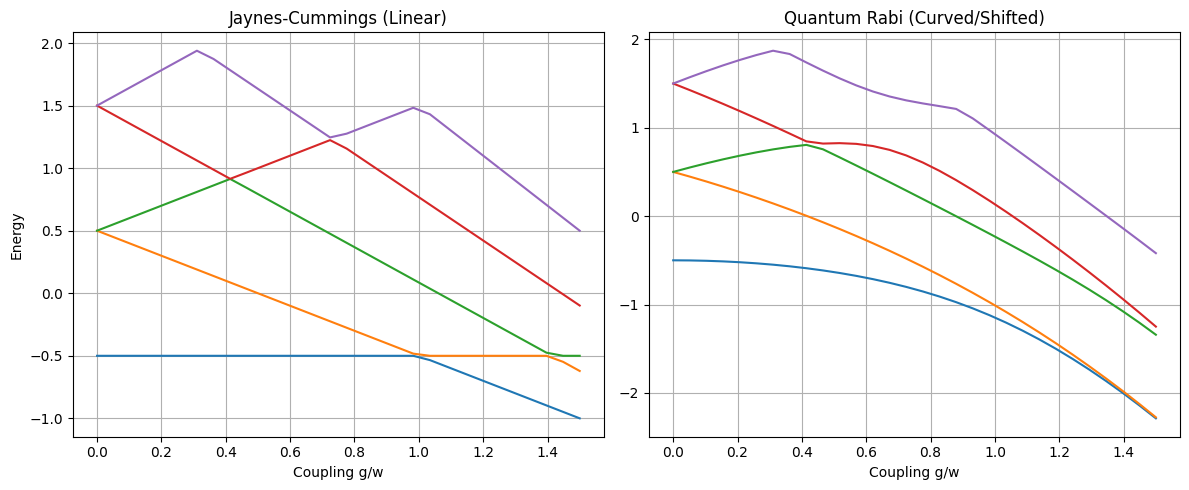

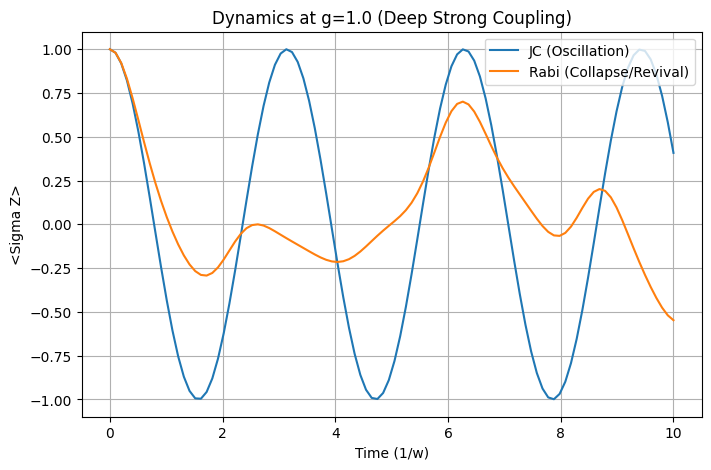

In [4]:
run_classical_benchmarks()

In [5]:
# =============================================================================
# PART 3: DIGITAL SIMULATION (TROTTER) (FIGURE 3)
# =============================================================================

def run_digital_simulation():
    print("\n--- RUNNING DIGITAL SIMULATION (TROTTER) ---")
    # N=32 (6 Qubits) for high fidelity simulation
    N = 32; wc = 1.0; wa = 1.0; g = 1.0
    
    # UPDATED: Use hardware-matched parameters
    time_max = 10.0; t_steps = 100
    times = np.linspace(0, time_max, t_steps)
    
    print(f"Building Hamiltonian (N={N})...")
    op_rabi = get_pauli_op(wc, wa, g, N, 'rabi')

    observable = SparsePauliOp("Z" + "I"*5)
    initial_state = Statevector.from_label("0"*6) # Atom Excited
    
    results = []
    print("Running Time Evolution (Reps=5)...")
    for t in times:
        # FIX: Force reps=5 to match hardware conditions exactly
        evo_gate = PauliEvolutionGate(op_rabi, time=t, synthesis=LieTrotter(reps=5))
        val = initial_state.evolve(evo_gate).expectation_value(observable).real
        results.append(val)
        
    plt.figure(figsize=(10, 5))
    plt.plot(times, results, '-', color='orange', linewidth=2, label="Rabi Quantum Sim (reps=5)")
    plt.title(f"Quantum Circuit Simulation: Collapse & Revival (g={g})")
    plt.xlabel("Time"); plt.ylabel("<Sigma Z>")
    plt.ylim(-1.1, 1.1); plt.grid(True); plt.legend()
    # plt.savefig("./images/fig3_trotter_sim.png")
    print("Saved Figure 3")



--- RUNNING DIGITAL SIMULATION (TROTTER) ---
Building Hamiltonian (N=32)...
Running Time Evolution (Reps=5)...
Saved Figure 3


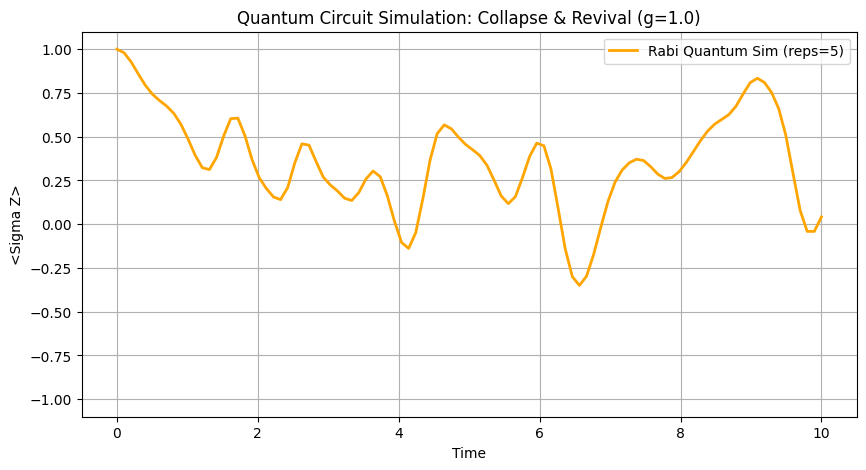

In [6]:
run_digital_simulation()

In [7]:
# =============================================================================
# PART 4: HARDWARE & NOISE ANALYSIS (FIGURE 4 & 5)
# =============================================================================

def run_hardware_analysis():
    print("\n--- RUNNING HARDWARE & NOISE ANALYSIS ---")
    
    # 1. RETRIEVE REAL HARDWARE DATA
    print(f"Retrieving Job {HARDWARE_JOB_ID} from IBM Quantum...")
    try:
        service = QiskitRuntimeService(channel="ibm_quantum_platform", token=MY_TOKEN)
    except:
        # Fallback for saved accounts
        service = QiskitRuntimeService(channel="ibm_quantum_platform")
        
    job = service.job(HARDWARE_JOB_ID)
    result = job.result()
    
    # Extract actual values from the job result
    hw_values = [float(pub.data.evs) for pub in result]
    print("Hardware data retrieved successfully.")
    
    # Hardware run parameters
    time_max = 5.0; t_steps = 20
    times_hw = np.linspace(0, time_max, t_steps)
    wc=1.0; wa=1.0; g=1.0
    
    # 2. HARDWARE VS IDEAL (Figure 4)
    op_hw = SparsePauliOp.from_list([("II", 0.5), ("IZ", -0.5), ("ZI", 0.5), ("XX", 1.0)])
    obs_hw = SparsePauliOp("ZI")
    
    est_ideal = StatevectorEstimator()
    ideal_results = []
    
    print("Calculating Ideal Baseline (Reps=5)...")
    for t in times_hw:
        qc = QuantumCircuit(2); qc.x(1)
        gate = PauliEvolutionGate(op_hw, time=t, synthesis=LieTrotter(reps=5)) # Match hardware reps
        qc.append(gate, [0, 1])
        val = est_ideal.run([(qc, obs_hw)]).result()[0].data.evs
        ideal_results.append(val)

    plt.figure(figsize=(10, 6))
    plt.plot(times_hw, ideal_results, 'b--', label="Ideal Simulation (reps=5)")
    plt.title("Ideal Simulation of Dynamics")
    plt.xlabel("Time"); plt.ylabel("<Sigma Z>"); plt.legend(); plt.grid(True)
    # plt.savefig("./images/fig4a_sim_results.png")
    print("Saved Figure 4a")

    plt.figure(figsize=(10, 6))
    plt.plot(times_hw, hw_values, 'ro-', label="Real Hardware (IBM Torino)")
    plt.plot(times_hw, ideal_results, 'b--', label="Ideal Simulation (reps=5)")
    plt.title("Real Quantum Hardware vs. Ideal")
    plt.xlabel("Time"); plt.ylabel("<Sigma Z>"); plt.legend(); plt.grid(True)
    # plt.savefig("./images/fig4_hardware_results.png")
    print("Saved Figure 4")

    # 3. NOISE MODEL ANALYSIS (Figure 5)
    noise_rate = 0.015 # 1.5% Error
    error_1q = depolarizing_error(noise_rate, 1)
    error_2q = depolarizing_error(noise_rate, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'ecr'])
    
    estimator_noisy = AerEstimator(
        backend_options={"method": "density_matrix", "noise_model": noise_model},
        run_options={"shots": 4000, "seed": 42}
    )
    
    print("Running Noisy Simulation (p=1.5%)...")
    circuits_noisy = []
    for t in times_hw:
        qc = QuantumCircuit(2); qc.x(1)
        gate = PauliEvolutionGate(op_hw, time=t, synthesis=LieTrotter(reps=5))
        qc.append(gate, [0, 1]); qc.measure_all()
        circuits_noisy.append(qc)
        
    job_noisy = estimator_noisy.run(circuits_noisy, [obs_hw]*len(times_hw))
    noisy_results = job_noisy.result().values
    
    plt.figure(figsize=(10, 6))
    plt.plot(times_hw, hw_values, 'ro-', label="Real Hardware")
    plt.plot(times_hw, noisy_results, 'g-.', label=f"Noisy Model (p={noise_rate})")
    plt.plot(times_hw, ideal_results, 'b--', label="Ideal Theory", alpha=0.5)
    plt.title("Noise Model Validation")
    plt.xlabel("Time"); plt.ylabel("<Sigma Z>"); plt.legend(); plt.grid(True)
    # plt.savefig("./images/fig5_noise_analysis.png")
    print("Saved Figure 5")


qiskit_runtime_service._discover_account:WARNING:2025-12-01 02:06:43,603: Loading account with the given token. A saved account will not be used.



--- RUNNING HARDWARE & NOISE ANALYSIS ---
Retrieving Job d4gvjrccdebc73f1in10 from IBM Quantum...


qiskit_runtime_service.__init__:WARNING:2025-12-01 02:06:55,086: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: IISc. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Hardware data retrieved successfully.
Calculating Ideal Baseline (Reps=5)...
Saved Figure 4a
Saved Figure 4
Running Noisy Simulation (p=1.5%)...


C:\Users\AK\AppData\Local\Temp\ipykernel_10032\3767351611.py:1: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  run_hardware_analysis()
C:\Users\AK\AppData\Local\Temp\ipykernel_10032\3767351611.py:1: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  run_hardware_analysis()


Saved Figure 5


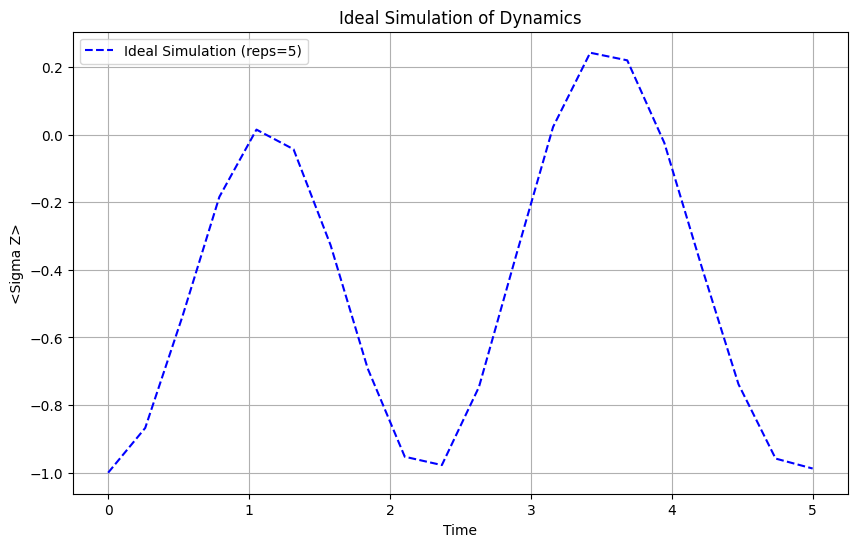

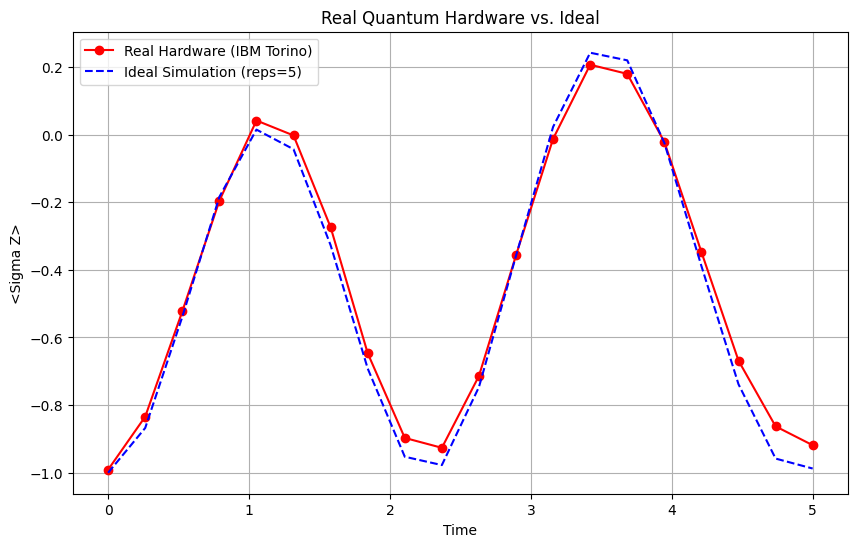

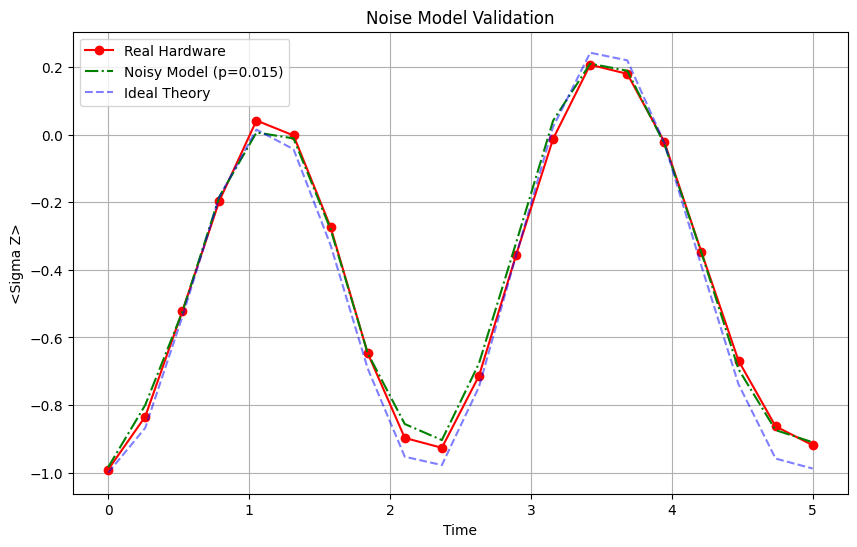

In [8]:
run_hardware_analysis()

In [9]:
# =============================================================================
# PART 5: QUANTUM VQE GROUND STATE COMPARISON (FIGURE 6)
# =============================================================================

def run_quantum_vqe_ground():
    print("\n--- RUNNING VQE GROUND STATE COMPARISON ---")
    N_exact = 20; N_q = 8
    wc = 1.0; wa = 1.0
    g_list = np.linspace(0, 1.5, 10)
    g_fine = np.linspace(0, 1.5, 50)
    
    # Classical Baseline
    print("Calculating Classical Baselines...")
    exact_jc = [eigvalsh(get_classical_matrix(wc, wa, g, N_exact, 'jc'))[0] for g in g_fine]
    exact_rabi = [eigvalsh(get_classical_matrix(wc, wa, g, N_exact, 'rabi'))[0] for g in g_fine]
    
    # Quantum VQE
    print("Running VQE Sweep (4 Qubits)...")
    vqe_jc = []
    vqe_rabi = []
    
    estimator = StatevectorEstimator()
    ansatz = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks='cz', reps=2)
    optimizer = COBYLA(maxiter=200)
    
    for g in g_list:
        # Run JC VQE
        op_jc = get_pauli_op(wc, wa, g, N_q, 'jc')
        vqe = VQE(estimator, ansatz, optimizer)
        res_jc = vqe.compute_minimum_eigenvalue(op_jc)
        vqe_jc.append(res_jc.eigenvalue.real)
        
        # Run Rabi VQE
        op_rabi = get_pauli_op(wc, wa, g, N_q, 'rabi')
        vqe = VQE(estimator, ansatz, optimizer)
        res_rabi = vqe.compute_minimum_eigenvalue(op_rabi)
        vqe_rabi.append(res_rabi.eigenvalue.real)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(g_fine, exact_jc, 'b--', label="Exact JC (RWA)")
    plt.plot(g_fine, exact_rabi, 'r-', label="Exact Rabi (No RWA)")
    plt.plot(g_list, vqe_jc, 'bo', label="VQE JC Ground")
    plt.plot(g_list, vqe_rabi, 'ro', label="VQE Rabi Ground")
    
    plt.xlabel("Coupling g/w"); plt.ylabel("Ground State Energy")
    plt.title("Ground State Shift: JC vs. Quantum Rabi (VQE)")
    plt.legend(); plt.grid(True)
    # plt.savefig("./images/fig6_vqe_ground_state.png")
    print("Saved Figure 6")



--- RUNNING VQE GROUND STATE COMPARISON ---
Calculating Classical Baselines...
Running VQE Sweep (4 Qubits)...
Saved Figure 6


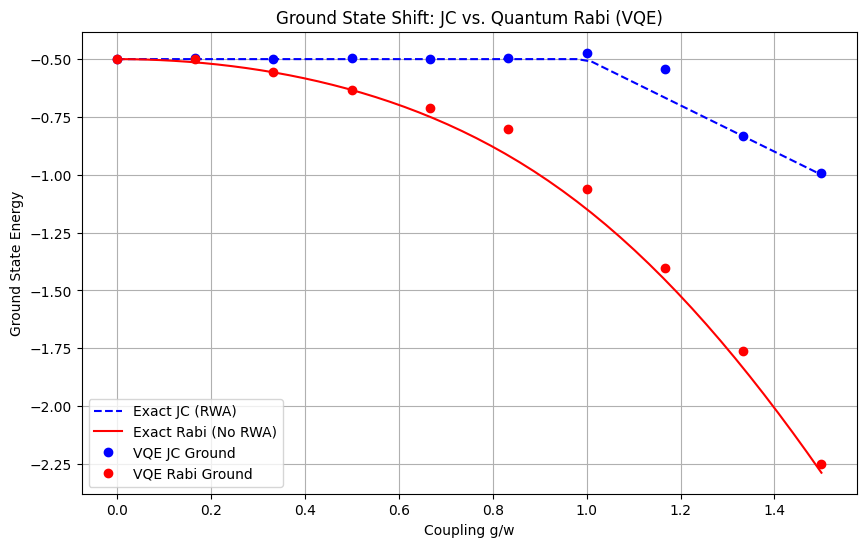

In [10]:
run_quantum_vqe_ground()